# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

- The data represents **17 marketing campaigns**. These campaigns occurred at a Portuguese bank between May 2008 and November 2010, resulting in a total of 79,354 contacts.
- During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. There were 6499 successes (an 8% success rate).

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV


from sklearn.metrics import classification_report, accuracy_score, recall_score


import time 

import warnings
# Hide the "Unknown categories" warning specifically
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.preprocessing._encoders")

#### Sections 

- [Model Comparisons](#Problem-10:-Model-Comparisons)
- [Model Tuning](#Model-Tuning)

[Bottom](#Bottom)



In [2]:
# Read data from csv
bank_df = pd.read_csv('data/bank-additional-full.csv', sep = ';')    #semicolon as separator

In [3]:
# Display the dataframe
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Display df statistics
bank_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


In [5]:
# Size of the dataframe: rows and feature columns
bank_df.shape

(41188, 21)

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [6]:
# Display df information, shape - number of rows and columns, column names and data types
# Info does not show missing values. Counts are all 41188

bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [7]:
# Double check missing values
bank_df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

#### Feature Columns and Unique Values
- inpect columns and values

In [8]:
# Columns with object type
categorical_cols = bank_df.select_dtypes(include='object')

categorical_cols.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [11]:
# Job unique values
bank_df['job'].unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

In [12]:
# Marital unique values
bank_df['marital'].unique()

array(['married', 'single', 'divorced', 'unknown'], dtype=object)

In [13]:
# Education unique values
bank_df['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

In [14]:
# Default values 
# Housing and loan have similar values

bank_df['default'].unique()

array(['no', 'unknown', 'yes'], dtype=object)

In [15]:
# Contact values
bank_df['contact'].unique()

array(['telephone', 'cellular'], dtype=object)

In [16]:
# Month values
bank_df['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr',
       'sep'], dtype=object)

In [17]:
# Day values
bank_df['day_of_week'].unique()

array(['mon', 'tue', 'wed', 'thu', 'fri'], dtype=object)

In [18]:
# Poutcome values
bank_df['poutcome'].unique()

array(['nonexistent', 'failure', 'success'], dtype=object)

In [19]:
# y-target variable
bank_df['y'].unique()

array(['no', 'yes'], dtype=object)

#### Plotting Some Distributions

In [20]:
# Define a color scheme for the plot
color_scheme = ['blue', 'orange', 'green', 'red','lightgreen', 'skyblue', 'silver','gold', 'purple', 'brown', 'gray','olive', 'cyan']

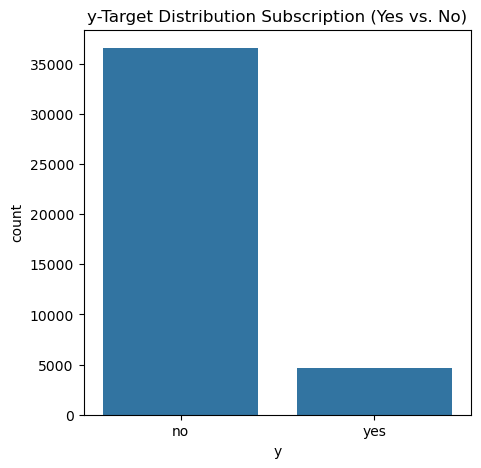

In [21]:
# Plot y-target distribution 
plt.figure(figsize=(5,5))
sns.countplot(x='y', data=bank_df)
plt.title('y-Target Distribution Subscription (Yes vs. No)')
plt.show()

- You will likely see that the 'no' group is the majority class. This represents **Class Imbalanced**.
  

In [22]:
# Job value count and get percentage
bank_job = bank_df['job'].value_counts().sort_values(ascending=True).reset_index()

# Calculate the percentage
bank_job['percentage'] = (bank_job['count'] / bank_job['count'].sum()) * 100
bank_job['percentage'] = bank_job['percentage'].round(2)
bank_job

,job,count,percentage
0,unknown,330,0.80
1,student,875,2.12
2,unemployed,1014,2.46
3,housemaid,1060,2.57
4,self-employed,1421,3.45
5,entrepreneur,1456,3.54
6,retired,1720,4.18
7,management,2924,7.10
8,services,3969,9.64
9,technician,6743,16.37


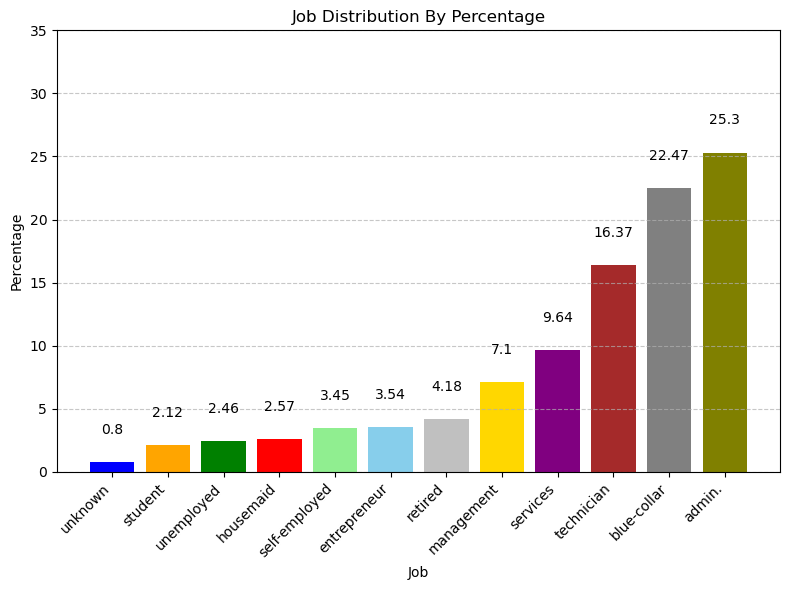

In [23]:
# Job distribution  plot

plt.figure(figsize=(8, 6))
plt.bar(bank_job['job'], bank_job['percentage'], color= color_scheme)

# Labels and title
plt.title('Job Distribution By Percentage')
plt.xlabel('Job'); plt.ylabel('Percentage')
plt.ylim(0,35)

# Add value labels on top of the bars
for i, count in enumerate(bank_job['percentage']):
    plt.text(i, count + 2, f'{count}', ha='center', va='bottom', fontsize=10)


# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Rotate the X-axis tick labels by 45 degrees
plt.xticks(rotation = 45, ha = 'right')

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

- Admins, blue-collar, and technicians are the top job types.
- Looking at the other end, we can assume that less than 5% bank customers have no income or generate no income (between unknown and unemployed), and are more likely 'not' to subscribe to term deposit.

In [24]:
# Marital distribution 

bank_marital = bank_df['marital'].value_counts().sort_values(ascending=True).reset_index()

# Calculate the percentage
bank_marital['percentage'] = (bank_marital['count'] / bank_marital['count'].sum()) * 100
bank_marital['percentage'] = bank_marital['percentage'].round(2)
bank_marital

,marital,count,percentage
0,unknown,80,0.19
1,divorced,4612,11.20
2,single,11568,28.09
3,married,24928,60.52


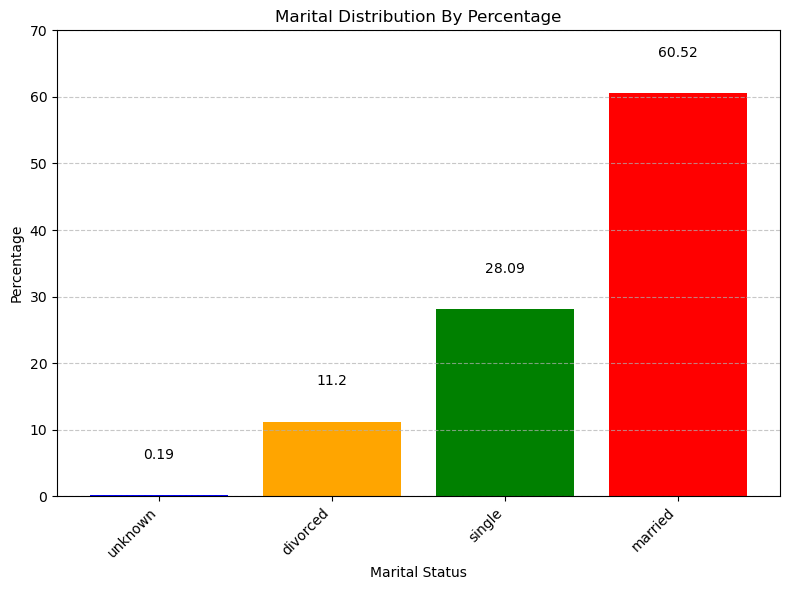

In [25]:
# Marital distribution plot

plt.figure(figsize=(8, 6))
plt.bar(bank_marital['marital'], bank_marital['percentage'], color= color_scheme)

# Add labels and title
plt.title('Marital Distribution By Percentage')
plt.xlabel('Marital Status'); plt.ylabel('Percentage')
plt.ylim(0,70)

# Add value labels on top of the bars
for i, count in enumerate(bank_marital['percentage']):
    plt.text(i, count + 5, f'{count}', ha='center', va='bottom', fontsize=10)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Rotate the X-axis tick labels by 45 degrees
plt.xticks(rotation = 45, ha = 'right')

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

- Married couple make up 60% of the dataset, this is mildly imbalance but models might handle this easily.

In [26]:
# Random sampling to see different values in the dataframe
bank_df.sample(25, random_state=44)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
4882,42,self-employed,married,university.degree,no,no,no,telephone,may,wed,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
13155,33,self-employed,married,university.degree,no,yes,no,cellular,jul,wed,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
27566,54,admin.,divorced,high.school,no,no,no,cellular,nov,fri,...,2,999,1,failure,-0.1,93.200,-42.0,4.021,5195.8,no
18195,36,technician,married,high.school,no,no,no,cellular,jul,wed,...,4,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no
8027,33,admin.,married,high.school,no,yes,no,telephone,jun,mon,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.865,5228.1,no
34314,26,student,single,unknown,no,yes,yes,cellular,may,thu,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,no
25485,36,technician,married,university.degree,no,no,no,cellular,nov,wed,...,4,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,no
37752,34,unemployed,single,professional.course,no,no,no,cellular,aug,fri,...,2,2,1,success,-2.9,92.201,-31.4,0.849,5076.2,yes
6822,25,services,married,high.school,no,yes,no,telephone,may,wed,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
19375,36,self-employed,married,basic.4y,unknown,yes,no,cellular,aug,wed,...,4,999,0,nonexistent,1.4,93.444,-36.1,4.967,5228.1,no


In [27]:
# Inspect campaign to see values
campaign_counts = bank_df['campaign'].value_counts()
campaign_counts

campaign
1     17642
2     10570
3      5341
4      2651
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
16       51
15       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
28        8
26        8
25        8
31        7
30        7
35        5
32        4
33        4
34        3
42        2
40        2
43        2
56        1
39        1
41        1
37        1
Name: count, dtype: int64

In [28]:
# See max campaign
bank_df['campaign'].max()

56

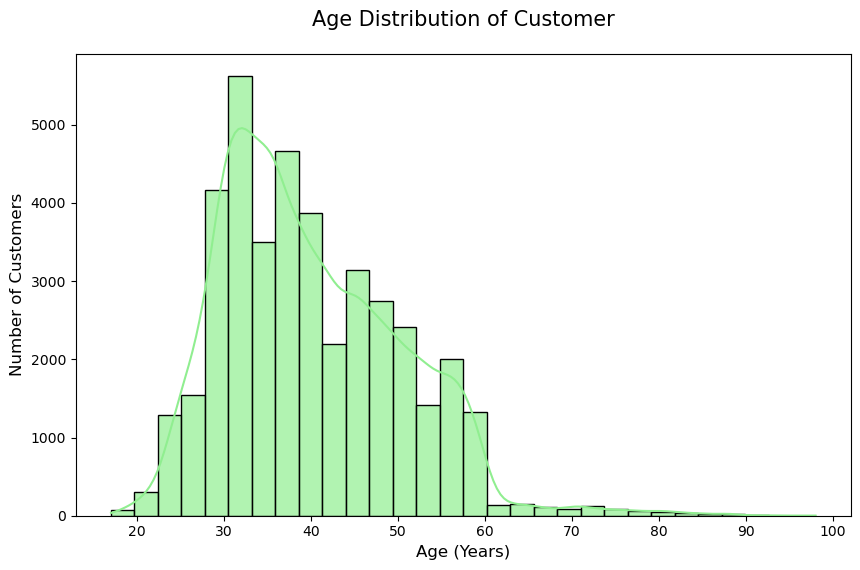

In [29]:
# Age distribution 

plt.figure(figsize=(10, 6))

# Distribution by percentage
ax = sns.histplot(data=bank_df, x='age', bins=30, kde=True, 
                   color='lightgreen', alpha=0.7)

# Labels
plt.title('Age Distribution of Customer', fontsize=15, pad=20)
plt.xlabel('Age (Years)', fontsize=12)
plt.ylabel("Number of Customers", fontsize=12 )

plt.show()

- The plot shows a right-skewed distribution, the average is between 30 and 40. People in their 30s and 40s have high expenses( mortgage, credit cards, children)
  thus, they are often hard to convert subscription.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Goals:
- The main goal is to build a predictive model to find out which existing customers are most likely to say "yes" or "no" to subscribe on bank term deposit subscription.
- Another objective is to improve marketing efficiency by identifying the attributes that lead to higher conversion rates. These factors will allow the bank to reduce wasted effort on mass phone calls and marketing spend by targeting and identifying customers that are likely to subscribe.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [30]:
# Show info
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

#### Check for Duplicate Records

In [31]:
# Check for duplicates 
bank_df.duplicated().sum()

np.int64(12)

In [32]:
# Inspect and display duplicates
duplicates = bank_df[bank_df.duplicated(keep=False)]
duplicates

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no


In [33]:
# Drop Duplicates 
bank_df.drop_duplicates(inplace=True)     # drop permanently


In [34]:
# Recheck if no more duplicates
bank_df.duplicated().sum()

np.int64(0)

#### Pdays (passed by days) Coersion
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- 0 means  "customer was contacted today," while 999 is a sentinel value that the client was never contacted, the model will interpret it literally that the customer was contacted 999 days ago. We may need to do feature engineering for this feature.

In [35]:
bank_df['pdays'].value_counts()

pdays
999    39661
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: count, dtype: int64

#### Pdays Coerce by creating a new binary flag column 
-  0 = for customer( pdays was 999) never contacted
-  1 = for repeat customers who was contacted 


In [36]:
# Create a new pdays_contacted column
bank_df['pdays_contacted'] = np.where(bank_df['pdays'] == 999, 0, 1)  

# Replace 999 with 0 in the original pdays column 
bank_df['pdays'] = bank_df['pdays'].replace(999,0)

In [37]:
# Verify p_days_contacted with 1 to double check transformation
bank_df[ bank_df['pdays_contacted'] == 1][:5]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_contacted
24108,37,admin.,married,university.degree,no,yes,no,telephone,nov,wed,...,6,1,success,-0.1,93.2,-42.0,4.286,5195.8,no,1
24264,48,management,married,university.degree,no,yes,no,cellular,nov,mon,...,4,1,success,-0.1,93.2,-42.0,4.191,5195.8,no,1
24279,42,technician,married,professional.course,unknown,yes,no,cellular,nov,mon,...,4,1,success,-0.1,93.2,-42.0,4.191,5195.8,no,1
24397,50,entrepreneur,married,university.degree,unknown,yes,no,cellular,nov,mon,...,3,1,success,-0.1,93.2,-42.0,4.191,5195.8,no,1
24482,36,self-employed,single,university.degree,no,yes,no,cellular,nov,mon,...,4,1,success,-0.1,93.2,-42.0,4.191,5195.8,no,1


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [38]:
# Map target y to numbers
bank_df['y'] = bank_df['y'].map({'yes': 1, 'no': 0})

#### Dropping Duration 
- Per documentation we will exclude duration
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [39]:
# Split data into features and target variable
X = bank_df.drop(['y','duration'], axis=1) 
y = bank_df['y']                               # 'y' is the target


In [40]:
# Split data into training and test sets
# Stratify - this ensures the 'yes'/'no' ratio is preserved in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [41]:
# Preprossessing train shape check
print("Verify train shape before preprocessing:\n", X_train.shape, y_train.shape)

Verify train shape before preprocessing:
 (32940, 20) (32940,)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [42]:
# Using DummyClassifier to get baseline model 
# DummyClassifier predicts the most frequent class which is the 'No'

dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)                # for Baseline + .score()
y_pred_dummy = dummy_clf.predict(X_test)

print("Baseline Accuracy with Dummy Classifier:")
baseline_score = dummy_clf.score(X_test, y_test)
print(f"{baseline_score:.3f}")



Baseline Accuracy with Dummy Classifier:
0.887


In [43]:
print("\n--- Detailed Report for Dummy Classifier ---")
print(classification_report(y_test, y_pred_dummy, zero_division=0))


--- Detailed Report for Dummy Classifier ---
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7308
           1       0.00      0.00      0.00       928

    accuracy                           0.89      8236
   macro avg       0.44      0.50      0.47      8236
weighted avg       0.79      0.89      0.83      8236



- The baseline score for our classifier is about 0.887
- By reading the 'Recall' result, a Recall of 0.0 for Class 1 is exactly what it is designed to do, since this is a Dummy Classifier.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [44]:
# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()


In [45]:
# Numeric transformer
numeric_transformer = Pipeline([
    ('num_imputer', SimpleImputer(strategy='median'))  # Fill with median, safety net for unseen data
    ])

# Categorical transformer
categorical_transformer = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='unknown')), # Fill with unknown, safety net for unseen data
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

In [46]:
# Preprocessing for both numerical and categorical data

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        # Impute numeric features
        ('numeric', numeric_transformer, numerical_features), 
        # Encode categorical features
        ('categories', categorical_transformer, categorical_features)
    ])



In [47]:
# Pipeline with Logisctic Regression default setting
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scale', StandardScaler()), 
    ('classifier', LogisticRegression(random_state=42))   # params class_weight='balanced', max_iter=1000 in order for the model to converge
    ])


# Fitting the model
pipeline.fit(X_train, y_train)
y_pred_logreg = pipeline.predict(X_test)

print("Training complete!")
print()

pipeline

Training complete!



,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('scale', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numeric', ...), ('categories', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different

### Problem 9: Score the Model

What is the accuracy of your model?

In [48]:
# Scoring the model
acc_score = accuracy_score(y_test, y_pred_logreg)

print(f"Logistic Regression Accuracy:  {acc_score:.3f}")

# 0.90 


Logistic Regression Accuracy:  0.898


In [49]:
print("\n--- Detailed Report for Logistic Regression ---")
print(classification_report(y_test, y_pred_logreg))


--- Detailed Report for Logistic Regression ---
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7308
           1       0.65      0.21      0.32       928

    accuracy                           0.90      8236
   macro avg       0.78      0.60      0.63      8236
weighted avg       0.88      0.90      0.87      8236



- The Baseline (0.887): This is the floor and just assumes everyone will say 'no'.

- Logistic Regression (0.898): It is better than the baseline because it is using default weight to keep its accuracy higher.

- Notice the Recall on class 1 is low 0.21. If we fine tune with weight_imbalance, Recalll should go up.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  **Using the default settings for each of the models**, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [50]:
# Models
# Using defaults settings

models = {
    "Logistic Regression": LogisticRegression(random_state=42),    
    "KNN": KNeighborsClassifier(),                                                                         
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(random_state=42)
}

# NOTE: KNN does not support class_weight parameter, class_weight='balanced' , probability=True,

In [51]:
# Result storage
results = []

# Compute time
start_loop = time.time()

# For loop to go over each model to train, calculate the accuracy scores and save the results
for name, model in models.items():

    print(f"--- Training {name} ")
    
    # Reset classifier and fitting the model
    pipeline.set_params(classifier = model)    # classifier is the named_step in the pipeline
    
    # Set Timer
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    
    # Train time
    train_time = time.time() - start_time
    
    # Get predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate accuracy scores
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    

    # Append the results in dictionary
    results.append({
        'Model': name,
        'Train Time (sec)': round(train_time, 2),
        'Train Accuracy': round(train_acc, 4),
        'Test Accuracy': round(test_acc, 4), 
        'Gap': round(train_acc - test_acc, 4),
        
    })

    # Calculate iteration timer
   
    iter_timer = time.time() - start_time
    print(f"--- {name} Complete! --- iter time: {iter_timer: .2f} sec\n")
 

loop_time = time.time() - start_loop
print(f"Total For-Loop Time: {loop_time:.2f} sec\n")


--- Training Logistic Regression 
--- Logistic Regression Complete! --- iter time:  0.99 sec

--- Training KNN 
--- KNN Complete! --- iter time:  15.73 sec

--- Training Decision Tree 
--- Decision Tree Complete! --- iter time:  2.04 sec

--- Training SVM 
--- SVM Complete! --- iter time:  443.58 sec

Total For-Loop Time: 462.35 sec



#### Model Performance with Default Settings

In [53]:
# Save training results in dataframe
model_comparisons_df = pd.DataFrame(results)
model_comparisons_df

,Model,Train Time (sec),Train Accuracy,Test Accuracy,Gap
0,Logistic Regression,0.68,0.9009,0.8983,0.0026
1,KNN,0.41,0.9120,0.8915,0.0206
2,Decision Tree,1.71,0.9952,0.8417,0.1535
3,SVM,279.35,0.9106,0.8985,0.0121


- Logistic Regression, KNN and Decision Tree are very fast to train. SVM has the slowest training time.
- Train Accuracy scores for Logistic Regression, KKN and SVM are close to each other while Decision Tree is the highest.
- Test Accurary scores for Logistic Regression, KKN and SVM are close to each other while Decision Tree is the lowest.
- Decision Tree has the highest Train Accuracy (99%) basically it memorized the training data and has lowest Test Accuracy suggesting it is overfitting.
- Logistic Regression and SVM are the two models that are showing excellent generalization, both gaps are tiny. These scores suggest these models perform well on unseen data.
- Logistic Regression is the best model among the 4 models by just using the default settings. Logistic Regression took 0.4 seconds to get 89% accuracy while SVM took the longest time(> 4 minutes) among the 4 models to get 89% accuracy.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

### Model Tuning

In [58]:
# Model Tuning. 
# #LogisticRegression(penalty='l1', solver='liblinear', random_state=42 )
# Note: KNN does not have class_weight parameter.

models_tune = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced')
    }

param_grids = {
    "Logistic Regression": {'classifier__C': [0.1, 1, 10]},
    "KNN": {'classifier__n_neighbors':list(range(1, 13, 2))},
    "Decision Tree": {'classifier__max_depth': [None, 5, 10, 15, 20]}  
    }

#knn_params = {'knn__n_neighbors': list(range(1, 22, 2)), 'knn__weights': ['uniform', 'distance'], 'knn__p': [1, 2]}  

In [59]:
# Storage for model tuning results
tune_results = []


In [67]:
# For loop to go over the model CV 5

start_loop = time.time()

for name, model in models_tune.items():
        
        print(f"--- Tuning {name} ")     
        
        # Update the pipeline to use the current model classifier
        pipeline.set_params(classifier=model)
        
        # Initialize GridSearch
        # Using 'recall' to score the class imbalance problem
        grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='recall')  #, n_jobs=-1

        # Set timer for training
        start_time = time.time()
        grid.fit(X_train, y_train)
        train_time = time.time() - start_time
    
        # Predictions using the best version of this model
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        
        # Calculate scores
        train_acc = best_model.score(X_train, y_train)
        test_acc = best_model.score(X_test, y_test)
        test_recall = recall_score(y_test, y_pred)
            
        tune_results.append({
            'Model': name,
            'Train Time (sec)': train_time,
            'Train Accuracy': round(train_acc, 4),
            'Test Accuracy': round(test_acc, 4),
            'Gap': round(train_acc - test_acc, 4),
            'Test Recall': round(test_recall, 4),         
            'Best Params': grid.best_params_
        }) 
        
        iter_timer = time.time() - start_time
        print(f"--- {name} Tuning Complete! - iter time: {iter_timer: .2f} sec\n")


print()
print("Model Tuning Complete!\n")

loop_time = time.time() - start_loop
print(f"Total For-Loop Time: {loop_time:.2f} sec\n")


--- Tuning Logistic Regression 
--- Logistic Regression Tuning Complete! - iter time:  8.00 sec

--- Tuning KNN 
--- KNN Tuning Complete! - iter time:  56.80 sec

--- Tuning Decision Tree 
--- Decision Tree Tuning Complete! - iter time:  13.64 sec


Model Tuning Complete!

Total For-Loop Time: 78.45 sec



In [61]:
# Fix to see the full content of the DataFrame, max width to 'None' (unlimited)
# To reset display: pd.reset_option('display.max_colwidth')

pd.set_option('display.max_colwidth', None)


#### Model Tuning Performance with Hyperparameters Tuning and GridSearch

In [62]:
model_tuning_df = pd.DataFrame(tune_results)
model_tuning_df

,Model,Train Time (sec),Train Accuracy,Test Accuracy,Gap,Test Recall,Best Params
0,Logistic Regression,6.208022,0.8288,0.8299,-0.0011,0.6455,{'classifier__C': 0.1}
1,KNN,51.032179,0.9950,0.8492,0.1458,0.3244,{'classifier__n_neighbors': 1}
2,Decision Tree,20.763708,0.8452,0.8476,-0.0024,0.6304,{'classifier__max_depth': 5}


In [55]:
# Output tuning results in plain
#tune_results

In [63]:
# Model Tuning for SVM separately

# Separating SVM tuning since it is the slowest model that takes too long to train.
# For the purpose of fine tuning, troubleshooting and debugging

models_tune2 = {
    "SVM": SVC(random_state=42, class_weight='balanced', probability=True)  # probability=True, 
    }

# Linear is slow in SVC for large data
# scale lowers the gamma, for data that is spread out
# C is penalty or strict parameter

param_grids2 = {
    "SVM": {'classifier__kernel': ['rbf'], 'classifier__gamma': ['scale', 0.01], 'classifier__C': [0.1, 1] }
    }


In [64]:
# For loop to go over the model 

start_loop = time.time()

for name, model in models_tune2.items():
        
        print(f"--- Tuning {name} ")     
        
        # Update the pipeline to use the current model classifier
        pipeline.set_params(classifier=model)
        
        # Initialize GridSearch
        # Using 'recall' to score the class imbalance problem
        # Include verbose output since it is taking too long
        # n_jobs will do multiple fit at the same time
        grid = GridSearchCV(pipeline, param_grids2[name], cv=2, scoring='recall', n_jobs=-1, verbose=3)   

        # Set timer for training
        start_time = time.time()
        grid.fit(X_train, y_train)
        train_time = time.time() - start_time
    
        # Predictions using the BEST version of this model
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        
        # Calculate scores
        train_acc = best_model.score(X_train, y_train)
        test_acc = best_model.score(X_test, y_test)
        test_recall = recall_score(y_test, y_pred)
            
        tune_results.append({
            'Model': name,
            'Train Time (sec)': train_time,
            'Train Accuracy': round(train_acc, 4),
            'Test Accuracy': round(test_acc, 4),
            'Gap': round(train_acc - test_acc, 4),
            'Test Recall': round(test_recall, 4),         
            'Best Params': grid.best_params_
        }) 
        
        iter_timer = time.time() - start_time
        print(f"--- {name} Tuning Complete! - iter time: {iter_timer: .2f} sec\n")


print()
print("Model Tuning Complete!")

loop_time = time.time() - start_loop
print(f"Total For-Loop Time: {loop_time:.2f} sec\n")

#NOTE: Long wait runtime 30-45 minutes

--- Tuning SVM 
Fitting 2 folds for each of 4 candidates, totalling 8 fits
--- SVM Tuning Complete! - iter time:  2622.31 sec


Model Tuning Complete!
Total For-Loop Time: 2622.31 sec



## Model Performance with Default Settings (Review)

In [60]:
model_comparisons_df

,Model,Train Time (sec),Train Accuracy,Test Accuracy,Gap
0,Logistic Regression,0.43,0.9009,0.8983,0.0026
1,KNN,0.24,0.9120,0.8915,0.0206
2,Decision Tree,0.97,0.9952,0.8417,0.1535
3,SVM,219.75,0.9106,0.8985,0.0121


## Model Performance with Fine Tuning

In [66]:
model_tuning_df = pd.DataFrame(tune_results)
display(model_tuning_df)

,Model,Train Time (sec),Train Accuracy,Test Accuracy,Gap,Test Recall,Best Params
0,Logistic Regression,6.208022,0.8288,0.8299,-0.0011,0.6455,{'classifier__C': 0.1}
1,KNN,51.032179,0.9950,0.8492,0.1458,0.3244,{'classifier__n_neighbors': 1}
2,Decision Tree,20.763708,0.8452,0.8476,-0.0024,0.6304,{'classifier__max_depth': 5}
3,SVM,2406.741062,0.8396,0.8428,-0.0031,0.6401,"{'classifier__C': 0.1, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}"


### Interpretation and Comparisons

**Hyperparameters Used in Grid Search for Fine Tuning**

```

models_tune = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced')
    }

param_grids = {
    "Logistic Regression": {'classifier__C': [0.1, 1, 10]},
    "KNN": {'classifier__n_neighbors':list(range(1, 13, 2))},
    "Decision Tree": {'classifier__max_depth': [None, 5, 10, 15, 20]}  
    }


```

To address the class imbalance in the dataset, we implemented class_weight='balanced' during the hyperparameter tuning phase to prevent the model from being biased toward the majority class. This ensures the model prioritizes Recall over Accuracy. And as a result of the trade-off, the Accuracy will likely to drop, but it enhances Recall. This ensures the model is optimized for sensitivity within the minority class, where the cost of missed detection is highest.

- Logistic regression is the best model. It has the highest Recall(64.5%) and the lowest training time(7.28 sec)
- We can tell the bank that we can use Logistic regression, a fast model that can catches the most "Yes" term subscribers(64.5%)
- KNN only looks at 1 neighbor and much likely just memorizing the training data(99.5% accuracy). It suggest it is overfitting. This model is not a good choice for this dataset.
- Decision Treee is reliabe with a Recall(63%) but the tree max_depth:5 is shallow.
- SVM chooses a low values for gamma: 0.01 and C: 01, meaning the model chose a simple boundary shape. The Recall performance (64%) is so close to Logistic Regression but the extra training time( over 30-45 minutes) for 2 CV-Folds is computationaly excessive.

### Feature Importance 

In [62]:
# Use Logistic Regression Fined Tuned Hyperparameters
# params class_weight='balanced', max_iter=1000 in order for the model to converge

logreg_results = []

logreg_pipe = Pipeline([('preprocessor', preprocessor),
                        ('scale', StandardScaler()), 
                        ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))   
                        ])

logreg_param_grid = {'classifier__C': [0.1, 1, 10]}
    

logreg_grid = GridSearchCV( logreg_pipe, param_grid=logreg_param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=3)


# Set timer for training
start_time = time.time()
logreg_grid.fit(X_train, y_train)
train_time = time.time() - start_time
    
# Predictions using the BEST version of this model
best_model = logreg_grid.best_estimator_
y_pred = best_model.predict(X_test)
        
# Calculate scores
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)
test_recall = recall_score(y_test, y_pred)
            
logreg_results.append({
'Model': 'Logistic Regression',
'Train Time (sec)': train_time,
'Train Accuracy': round(train_acc, 4),
'Test Accuracy': round(test_acc, 4),
'Gap': round(train_acc - test_acc, 4),
'Test Recall': round(test_recall, 4),         
'Best Params':logreg_grid.best_params_
})

print("Complete!")


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Complete!


In [71]:
logreg_results

best_model_df = pd.DataFrame(logreg_results)
display(best_model_df)

,Model,Train Time (sec),Train Accuracy,Test Accuracy,Gap,Test Recall,Best Params
0,Logistic Regression,10.355083,0.8288,0.8299,-0.0011,0.6455,{'classifier__C': 0.1}


In [65]:
# Heatmap correlation 

best_pipe = logreg_grid.best_estimator_

# Get the transformed data from the preprocessor and scale it 
# This ensures the data matches what the Logistic Regression use in fitting
X_transformed = best_pipe.named_steps['preprocessor'].transform(X_train)
X_scaled = best_pipe.named_steps['scale'].transform(X_transformed)


#  Get the new column names encoded by OneHotEncoder
feature_names = best_pipe.named_steps['preprocessor'].get_feature_names_out()

# Create a temporary DataFrame for plotting
bank_df_corr = pd.DataFrame(X_scaled, columns=feature_names)

# Add the target 'y' back in so we can see its correlation with features
# We reset the index to ensure it aligns perfectly with the transformed numpy array
bank_df_corr['target_y'] = y_train.values




<Axes: >

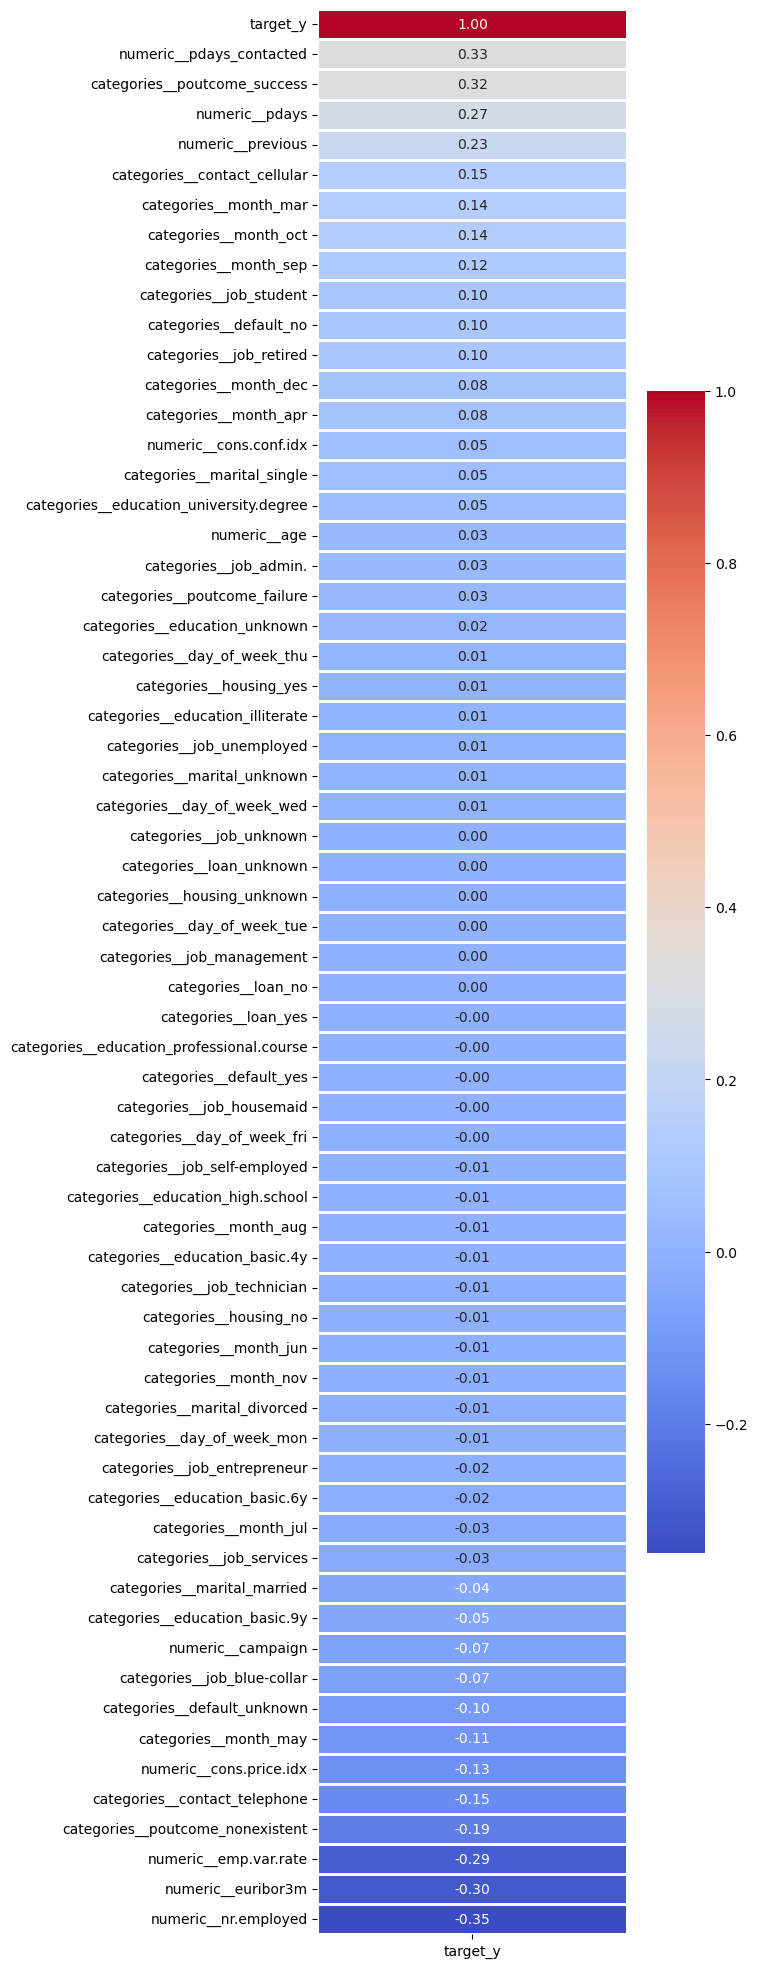

In [74]:
# Plot only for target y 

plt.figure(figsize=(5, 25))   # width/height

# Calculate the correlation matrix for target y only
target_corr = bank_df_corr.corr()[['target_y']].sort_values(by='target_y', ascending=False)  # note to double bracket


sns.heatmap(target_corr, annot=True, fmt=".2f", cmap='coolwarm', linewidth=1)

- The top 3 correlation are pdays_contacted, poutcome_success, and pdays. 
- Note that earlier data exploration, we applied feature engineering on pdays which resulted to pdays_contacted.

#### Feature Importance

In [72]:
# Coefficient Check to get Feature Importance

#Extract the coefficients from the logistic regression step
# coef_ is a 2D array, so we use [0] to get the 1D version
coefs = best_pipe.named_steps['classifier'].coef_[0]


feat_importance_df = pd.DataFrame({'Features': feature_names, 'Coefficients': coefs})

#feat_importance_df['Coefficients'] = feat_importance_df['Coefficients'].apply(abs)     #Dont apply, there can be positive and negative coefs

feat_importance_df = feat_importance_df.sort_values(by = 'Coefficients', ascending = False)


# Clean feature names
feat_importance_df['Features'] = feat_importance_df['Features'].str.replace('numeric__', '', regex=False)    #.str.replace('onehotencoder__', '', regex=False)
feat_importance_df['Features'] = feat_importance_df['Features'].str.replace('categories__', '', regex=False)



In [75]:
print("Strongest Feature Importance")
print("Feature Importance Count: ", feat_importance_df.shape[0])

feat_importance_df[:20]     # Display first 20 features


Strongest Feature Importance
Feature Importance Count:  63


,Features,Coefficients
5,cons.price.idx,0.849202
7,euribor3m,0.346649
9,pdays_contacted,0.308762
46,month_aug,0.203550
50,month_mar,0.166105
43,contact_cellular,0.142525
8,nr.employed,0.109491
48,month_jul,0.101825
6,cons.conf.idx,0.090034
15,job_retired,0.073835


In [69]:
# Top Srongest Barriers
feat_importance_df[-20:].sort_values(by='Coefficients', ascending=True)


,Features,Coefficients
4,emp.var.rate,-1.740212
51,month_may,-0.188224
44,contact_telephone,-0.142525
1,campaign,-0.116045
49,month_jun,-0.100629
52,month_nov,-0.080182
3,previous,-0.078617
60,poutcome_failure,-0.068904
36,default_yes,-0.064829
2,pdays,-0.050562


In [ ]:
### Uncomment to see Full List of Feature Importance 
# feat_importance_df

#### The Strongest Predictors

- cons.price.idx:  Strongest predictor. Interestingly, as the consumer price index rises, subscriptions increase. This might suggest customers look for stable bank products when other prices are going up.

- euribor3m: Interest rates have a moderate positive pull on the outcome.

- pdays_contacted: Previous contact history is significant.

- month_aug / mar: Specific months provides seasonal advantage.

  
#### The Strongest Barriers
- emp.var.rate : This is the biggest barrier. High employment rate strongly suggest customers are less likely to subsribe

- month_may: May has the lowest conversion compared to the other months, even though it has the most volume call.

  
- contact_telephone: Calling people on their landlines is less successfull. 

- campaign: Suggesting increased client calls(spamming the customer), the likelihood of saying Yes drops. 



#### Demographic Insights
Positive Drivers: Being Single , a Student , or Retired have a higher chance of saying yes to term deposit.

Negative Drivers: Blue-collar workers , Divorced, and Unemployed  are less likely to subscribe.

#### Recommendations

The cons.price.idx and emp.var.rate are the 2 main dominant features positive and negative respectively.This means the subscription is extremely sensitive to the economy. When Employment Variation Rate is high(uncertainty), we need to scale back on cold calling as they will likely to fail. Instead, during stable or high Consumer Price Index, increase on marketing resource as the data shows that customers are more inclined to subsribe on long term deposits.

Multiple and constant campaign calls to the same person have a strong negative effect and draws customer away from saying yes, they are getting annoyed. A recommended approach is to manage minimum calls a week or a month and a planned scheduling.

[Top](#Top)

#### Bottom